Epoch [1/10], Loss: 1.4574, Accuracy: 46.89%
Epoch [2/10], Loss: 1.1615, Accuracy: 58.44%
Epoch [3/10], Loss: 1.0485, Accuracy: 62.76%
Epoch [4/10], Loss: 0.9770, Accuracy: 65.32%
Epoch [5/10], Loss: 0.9316, Accuracy: 67.08%
Epoch [6/10], Loss: 0.8936, Accuracy: 68.57%
Epoch [7/10], Loss: 0.8607, Accuracy: 69.41%
Epoch [8/10], Loss: 0.8315, Accuracy: 70.71%
Epoch [9/10], Loss: 0.8140, Accuracy: 71.32%
Epoch [10/10], Loss: 0.7945, Accuracy: 72.08%
Test Accuracy: 75.42%


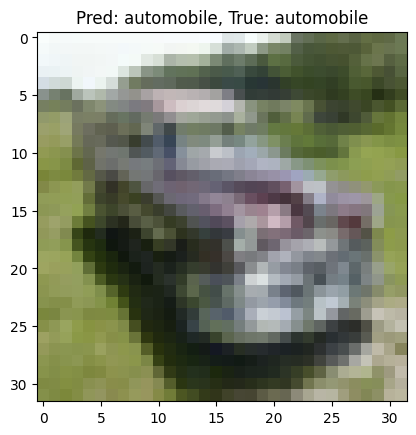

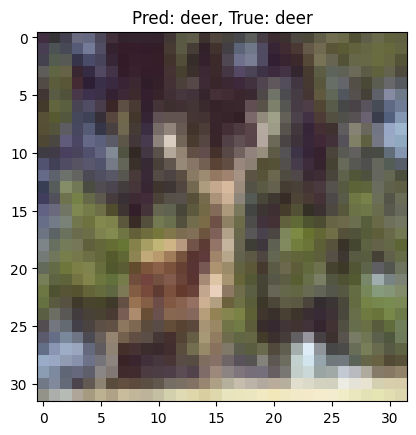

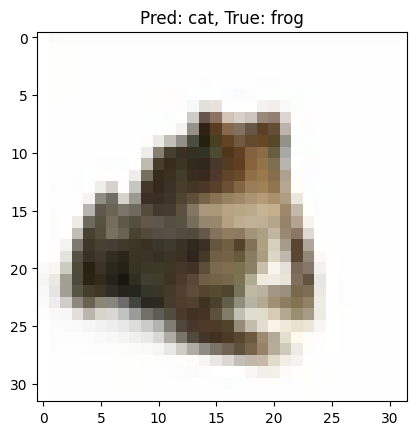

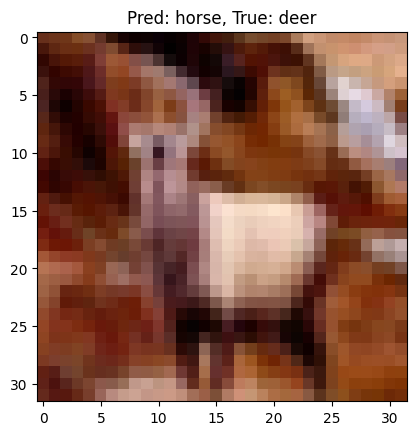

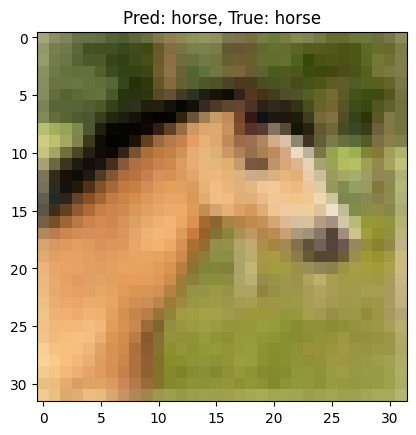

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms.functional import resize

# Data Augmentation for CIFAR-10 (Training Only)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),               # Random horizontal flip
    transforms.RandomCrop(32, padding=4),            # Random crop with padding
    transforms.RandomRotation(10),                   # Random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),             # Normalization
                         (0.5, 0.5, 0.5))
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# CIFAR-10 Classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Dummy Bounding Box Generator (Placeholder)
def generate_bounding_box(image_tensor):
    return torch.tensor([0.25, 0.25, 0.75, 0.75])  # Normalized bbox

# Model Definition
class CIFAR10ObjectDetector(nn.Module):
    def __init__(self):
        super(CIFAR10ObjectDetector, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_bbox = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

        self.fc_class = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        bbox = self.fc_bbox(x)
        cls = self.fc_class(x)
        return bbox, cls

# Instantiate model, loss, optimizer
model = CIFAR10ObjectDetector()
criterion_bbox = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop with Accuracy
epochs = 10
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

for epoch in range(epochs):
    correct = 0
    total = 0
    running_loss = 0

    for images, labels in train_loader:
        targets_bbox = torch.stack([generate_bounding_box(img) for img in images])
        targets_class = labels

        pred_bbox, pred_class = model(images)

        loss_bbox = criterion_bbox(pred_bbox, targets_bbox)
        loss_class = criterion_class(pred_class, targets_class)
        loss = loss_bbox + loss_class

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(pred_class, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Evaluation Accuracy
model.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        pred_bboxes, pred_classes = model(images)
        _, predicted = torch.max(pred_classes, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Show predictions for 5 test images
test_loader = torch.utils.data.DataLoader(test_data, batch_size=5, shuffle=True)
test_images, test_labels = next(iter(test_loader))
pred_bboxes, pred_classes = model(test_images)

for i in range(2):
    plt.imshow(test_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # unnormalize
    plt.title(f"Pred: {classes[torch.argmax(pred_classes[i])]}, True: {classes[test_labels[i]]}")
    plt.show()
